In [1]:
# import library
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.filters as filters

In [2]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img>tol        
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
      return img

def circle_crop_v2(img):
  img = crop_image_from_gray(img)

  height, width, depth = img.shape
  largest_side = np.max((height, width))
  img = cv2.resize(img, (largest_side, largest_side))

  height, width, depth = img.shape

  x = int(width / 2)
  y = int(height / 2)
  r = np.amin((x, y))

  circle_img = np.zeros((height, width), np.uint8)
  cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
  img = cv2.bitwise_and(img, img, mask=circle_img)
  img = crop_image_from_gray(img)

  return img

In [17]:
def extract_bv(image):
  image = image[:, :, 1] # Get green channel
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  contrast_enhanced_green_fundus = clahe.apply(image)
  # applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
  f5 = clahe.apply(f4)

  # removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255
  contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

  # removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
  # vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)
  xmask = np.ones(image.shape[:2], dtype="uint8") * 255
  xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      shape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	

  finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
  blood_vessels = cv2.bitwise_not(finimage)
  dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
  #dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
  blood_vessels_1 = cv2.bitwise_not(dilated)
  return blood_vessels_1

In [38]:
def exudate(img):
  # get green channel
  img = img[:,:,1]

  # Apply a median blur to remove salt-and-pepper noise
  img = cv2.medianBlur(img, 5)

  # Enhance the contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  # Apply Otsu's threshold
  _, thresholded = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

  # Invert the image to segment the exudates
  thresholded = 255 - thresholded

  # # Apply morphological operations to remove small connected components and fill holes
  kernel = np.ones((5, 5), np.uint8)
  thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

  return thresholded

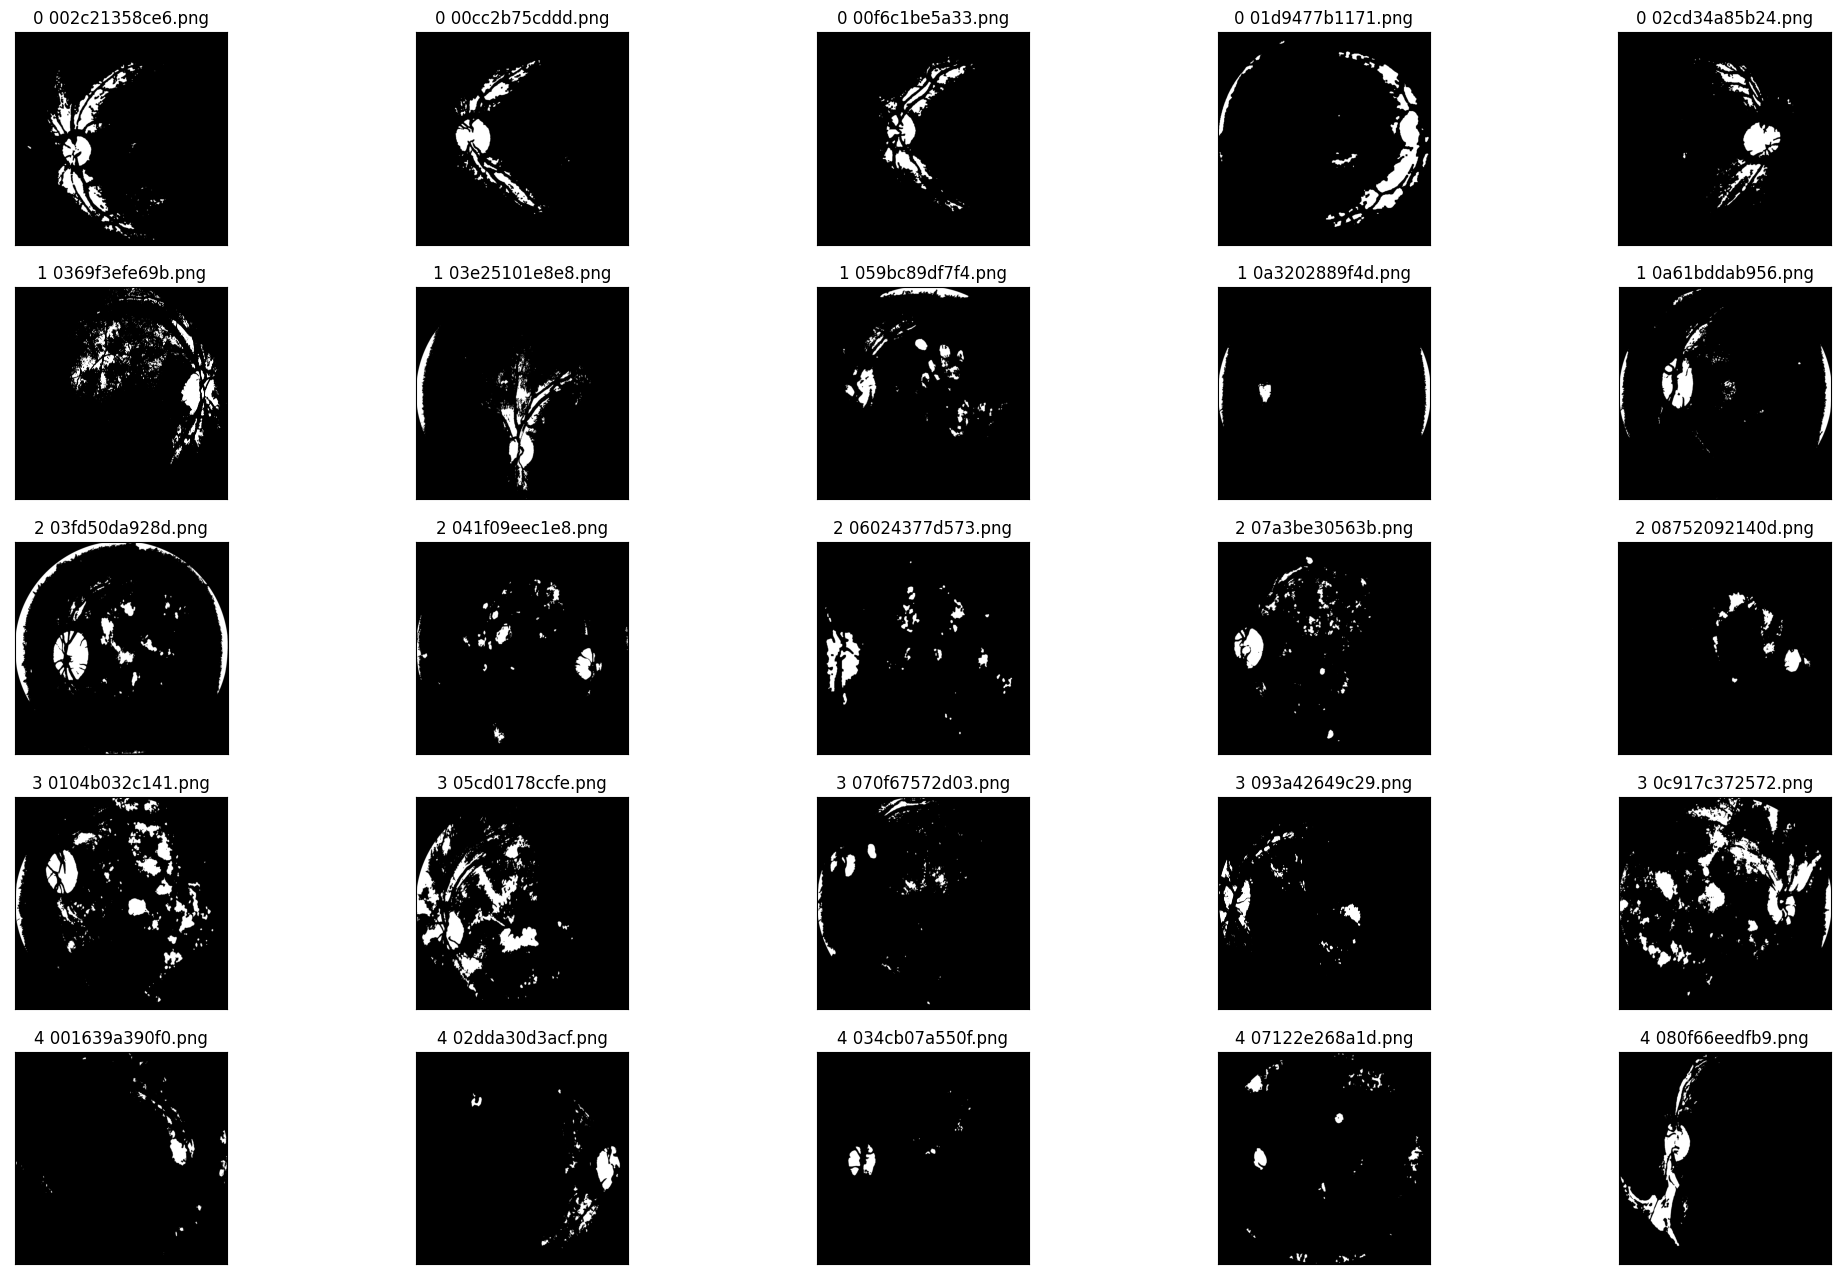

In [39]:
path_dataset = 'E:/Pawang Code/Diabetic Retinopathy/dataset_filter'
fig = plt.figure(figsize=(25, 16))
j= 0
for folder in os.listdir(path_dataset):
    sub_folder_files = os.listdir(os.path.join(path_dataset, folder))
    for i, filename in enumerate(sub_folder_files):
        ax = fig.add_subplot(5, 5, j+1, xticks=[], yticks=[])
        img = cv2.imread(os.path.join(path_dataset, folder, filename))
        img = circle_crop_v2(img)
        ex = exudate(img)
        bv = extract_bv(img)
        # mask exudate with original image
        # img[ex == 255] = [0, 0, 255]
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # remove blood vessels from exudate with mask method
        
        plt.imshow(ex, cmap='gray')
        ax.set_title(folder + ' ' + filename)
        j += 1
        if i == 4:
            break